In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text

import mpmp.config as cfg
import mpmp.utilities.analysis_utilities as au
import mpmp.utilities.plot_utilities as plu

In [2]:
# set results directory
old_results_dir = Path(cfg.results_dirs['mutation'],
                       'methylation_results',
                       'gene').resolve()

new_results_dir = Path(cfg.results_dirs['mutation'],
                       'methylation_results_shuffle_cancer_type',
                       'gene').resolve()

In [3]:
# load raw data
old_results_df = au.load_stratified_prediction_results(old_results_dir, 'gene')
new_results_df = au.load_stratified_prediction_results(new_results_dir, 'gene')

# here we want to use compressed data for methylation datasets (27k and 450k)
# the results in 02_classify_compressed/compressed_vs_raw_results.ipynb show that
# performance is equal or slightly better for PCA compressed methylation data,
# and it's much easier/faster to fit models on
old_results_df = old_results_df[old_results_df.training_data.isin(['expression'])].copy()
new_results_df = new_results_df[new_results_df.training_data.isin(['expression'])].copy()

old_compressed_results_df = au.load_compressed_prediction_results(old_results_dir, 'gene',
                                                                  old_filenames=True)
# load compressed data for me_27k and me_450k
old_compressed_results_df = old_compressed_results_df[
    (old_compressed_results_df.training_data.isin(['me_27k', 'me_450k'])) &
    (old_compressed_results_df.n_dims == 5000)
].copy()

new_compressed_results_df = au.load_compressed_prediction_results(new_results_dir, 'gene')
new_compressed_results_df = new_compressed_results_df[
    (new_compressed_results_df.training_data.isin(['me_27k', 'me_450k'])) &
    (new_compressed_results_df.n_dims == 5000)
].copy()

old_results_df['n_dims'] = 'raw'
old_results_df = pd.concat((old_results_df, old_compressed_results_df))
new_results_df['n_dims'] = 'raw'
new_results_df = pd.concat((new_results_df, new_compressed_results_df))

In [4]:
print(old_results_df.seed.unique())
print(old_results_df.training_data.unique())
print(old_results_df.n_dims.unique())
print(old_results_df.shape)
old_results_df.head()

[42  1]
['expression' 'me_450k' 'me_27k']
['raw' 5000]
(12096, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.99936,0.99278,MAP3K1,expression,signal,42,train,0,gene,raw
1,0.59870,0.14903,MAP3K1,expression,signal,42,test,0,gene,raw
2,0.66496,0.20677,MAP3K1,expression,signal,42,cv,0,gene,raw
3,0.99468,0.91588,MAP3K1,expression,signal,42,train,1,gene,raw
4,0.75569,0.40224,MAP3K1,expression,signal,42,test,1,gene,raw


In [5]:
print(new_results_df.seed.unique())
print(new_results_df.training_data.unique())
print(new_results_df.n_dims.unique())
print(new_results_df.shape)
new_results_df.head()

[42  1]
['expression' 'me_450k' 'me_27k']
['raw' 5000]
(12096, 10)


,auroc,aupr,identifier,training_data,signal,seed,data_type,fold,experiment,n_dims
0,0.99936,0.99278,MAP3K1,expression,signal,42,train,0,gene,raw
1,0.59870,0.14903,MAP3K1,expression,signal,42,test,0,gene,raw
2,0.66496,0.20677,MAP3K1,expression,signal,42,cv,0,gene,raw
3,0.99468,0.91588,MAP3K1,expression,signal,42,train,1,gene,raw
4,0.75569,0.40224,MAP3K1,expression,signal,42,test,1,gene,raw


In [6]:
old_shuffled_df = (
    old_results_df[(old_results_df.signal == 'shuffled') &
                   (old_results_df.data_type == 'test')]
).sort_values(by=['identifier', 'training_data', 'seed', 'fold'])
new_shuffled_df = (
    new_results_df[(new_results_df.signal == 'shuffled') &
                   (new_results_df.data_type == 'test')]
).sort_values(by=['identifier', 'training_data', 'seed', 'fold'])

shuffled_diff_df = old_shuffled_df.copy()
shuffled_diff_df['auroc_diff'] = old_shuffled_df['auroc'] - new_shuffled_df['auroc']
shuffled_diff_df['aupr_diff'] = old_shuffled_df['aupr'] - new_shuffled_df['aupr']
shuffled_diff_df = (shuffled_diff_df
    .drop(columns=['auroc', 'aupr', 'signal', 'experiment', 'n_dims', 'data_type'])
    .groupby(['identifier', 'training_data'])
    .mean()
    .reset_index()
    .drop(columns=['seed', 'fold'])
)

print(shuffled_diff_df.shape)
shuffled_diff_df.head()

(252, 4)


,identifier,training_data,auroc_diff,aupr_diff
0,ABL1,expression,0.116569,-0.003699
1,ABL1,me_27k,0.161577,0.022869
2,ABL1,me_450k,0.144425,0.030501
3,ALK,expression,0.001036,-0.021284
4,ALK,me_27k,0.006596,0.054730


Text(0.5, 1.0, 'Performance difference between new and old shuffling scheme')

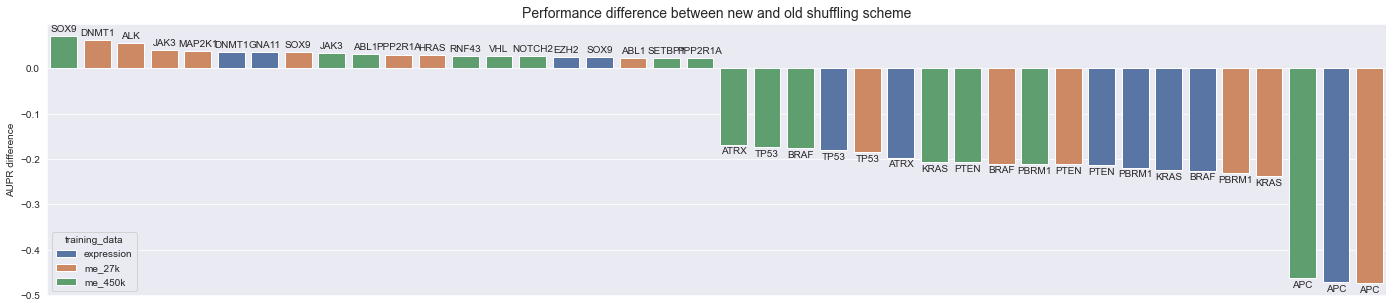

In [7]:
metric = 'aupr'
num_examples = 20

top_df = (shuffled_diff_df
    .sort_values(by='{}_diff'.format(metric), ascending=False)
    .head(num_examples)
)
bottom_df = (shuffled_diff_df
    .sort_values(by='{}_diff'.format(metric), ascending=False)
    .tail(num_examples)
)

plot_df = pd.concat((top_df, bottom_df)).reset_index()

sns.set({'figure.figsize': (24, 5)})
sns.barplot(data=plot_df, x=plot_df.index, y='{}_diff'.format(metric),
            hue='training_data',  dodge=False,
            hue_order=sorted(plot_df.training_data.unique()))

def show_values_on_bars(ax):
    for i in range(plot_df.shape[0]):
        _x = i
        _y = plot_df.loc[i, '{}_diff'.format(metric)]
        val = plot_df.loc[i, 'identifier']
        if _y > 0:
            ax.text(_x, _y + 0.01, val, ha="center") 
        else:
            ax.text(_x, _y - 0.02, val, ha="center") 
        
show_values_on_bars(plt.gca())
plt.gca().get_xaxis().set_visible(False)
plt.ylabel('{} difference'.format(metric.upper()))
plt.title('Performance difference between new and old shuffling scheme', size=14)

In [8]:
old_all_results_df = au.compare_all_data_types(old_results_df,
                                               0.05,
                                               metric='aupr')
old_all_results_df.head()

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
0,ABL1,0.009218,8.773569e-01,8.879275e-01,False,expression,0.051622
1,ALK,0.042557,4.188411e-02,5.497290e-02,False,expression,1.259851
2,AMER1,0.003778,8.062222e-01,8.360823e-01,False,expression,0.077751
3,APC,0.568111,1.491507e-08,1.252866e-07,True,expression,6.902095
4,ARID1A,0.428201,5.976045e-08,3.861445e-07,True,expression,6.413250


In [9]:
new_all_results_df = au.compare_all_data_types(new_results_df,
                                               0.05,
                                               metric='aupr')
new_all_results_df.head()

,gene,delta_mean,p_value,corr_pval,reject_null,training_data,nlog10_p
0,ABL1,0.005519,0.944453,0.955832,False,expression,0.019618
1,ALK,0.021273,0.417638,0.455605,False,expression,0.341412
2,AMER1,-0.025538,0.163668,0.202179,False,expression,0.694265
3,APC,0.096825,0.000039,0.000110,True,expression,3.960087
4,ARID1A,0.314699,0.000001,0.000008,True,expression,5.103798


In [10]:
compare_results_df = new_all_results_df.copy()
compare_results_df['mean_diff'] = new_all_results_df.delta_mean - old_all_results_df.delta_mean
compare_results_df.drop(columns=['delta_mean', 'p_value', 'corr_pval', 'reject_null', 'nlog10_p'],
                        inplace=True)
compare_results_df.head()

,gene,training_data,mean_diff
0,ABL1,expression,-0.003699
1,ALK,expression,-0.021284
2,AMER1,expression,-0.029316
3,APC,expression,-0.471286
4,ARID1A,expression,-0.113502


Text(0.5, 1.0, 'Performance difference between new and old shuffling scheme')

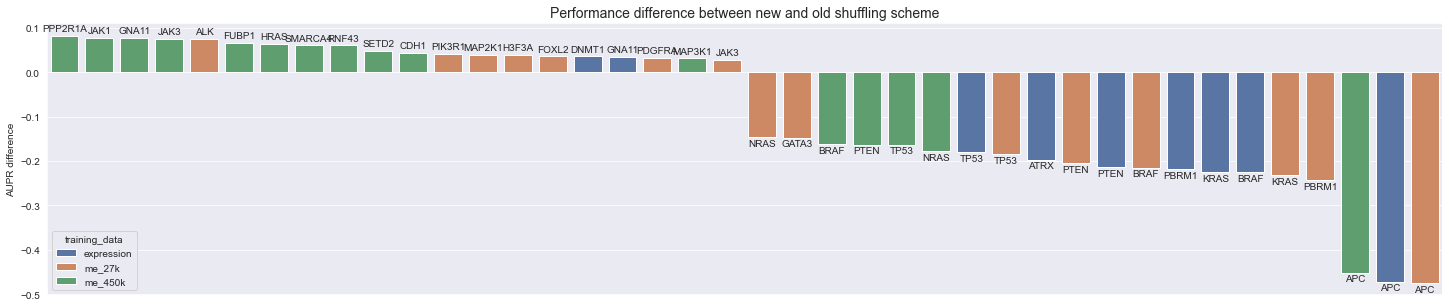

In [13]:
num_examples = 20

top_df = (compare_results_df
    .sort_values(by='mean_diff', ascending=False)
    .head(num_examples)
)
bottom_df = (compare_results_df
    .sort_values(by='mean_diff'.format(metric), ascending=False)
    .tail(num_examples)
)

plot_df = pd.concat((top_df, bottom_df)).reset_index()

sns.set({'figure.figsize': (25, 5)})
sns.barplot(data=plot_df, x=plot_df.index, y='mean_diff',
            hue='training_data', dodge=False,
            hue_order=sorted(plot_df.training_data.unique()))

def show_values_on_bars(ax):
    for i in range(plot_df.shape[0]):
        _x = i
        _y = plot_df.loc[i, 'mean_diff'.format(metric)]
        val = plot_df.loc[i, 'gene']
        if _y > 0:
            ax.text(_x, _y + 0.01, val, ha="center") 
        else:
            ax.text(_x, _y - 0.02, val, ha="center") 
        
show_values_on_bars(plt.gca())
plt.gca().get_xaxis().set_visible(False)
plt.ylabel('{} difference'.format(metric.upper()))
plt.title('Performance difference between new and old shuffling scheme', size=14)